In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import imageio

import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

In [12]:
path = '/Users/arun/Downloads'
image_path = os.path.join(path, 'leftImg8bit_trainvaltest/leftImg8bit/train')
mask_path = os.path.join(path, 'gtFine_trainvaltest/gtFine/train')
image_list = []
mask_list = []


In [13]:
# Iterate through city subdirectories
for city in os.listdir(image_path):
    city_image_path = os.path.join(image_path, city)
    city_mask_path = os.path.join(mask_path, city)
    
    if os.path.isdir(city_image_path) and not city.startswith('.'):
        image_list.extend([os.path.join(city_image_path, img) for img in os.listdir(city_image_path) if img.endswith('_leftImg8bit.png')])
        mask_list.extend([os.path.join(city_mask_path, msk) for msk in os.listdir(city_mask_path) if msk.endswith('_gtFine_labelIds.png')])

In [14]:
image_list.sort()
mask_list.sort()

/var/folders/xz/_q1lhz9n52lb8rsrv2yy36dm0000gn/T/ipykernel_3229/2745479700.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(image_list[N])
/var/folders/xz/_q1lhz9n52lb8rsrv2yy36dm0000gn/T/ipykernel_3229/2745479700.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  mask = imageio.imread(mask_list[N])


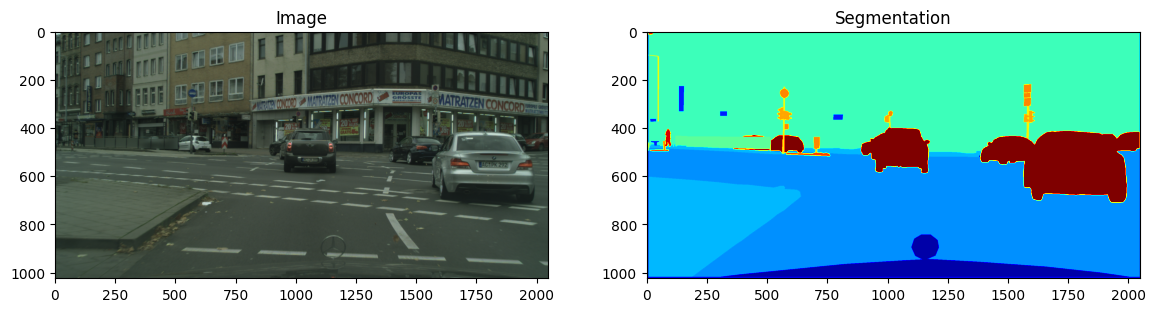

In [15]:
N = 3
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask, cmap='jet')
arr[1].set_title('Segmentation')
plt.show()

In [16]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'/Users/arun/Downloads/leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/Users/arun/Downloads/gtFine_trainvaltest/gtFine/train/aachen/aachen_000000_000019_gtFine_labelIds.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/Users/arun/Downloads/leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000001_000019_leftImg8bit.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/Users/arun/Downloads/gtFine_trainvaltest/gtFine/train/aachen/aachen_000001_000019_gtFine_labelIds.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/Users/arun/Downloads/leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000002_000019_leftImg8bit.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/Users/arun/Downloads/gtFine_trainvaltest/gtFine/train/aachen/aachen_000002_000019_gtFine_labelIds.png'>)


2025-08-02 16:49:46.949032: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [17]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'/Users/arun/Downloads/leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png', shape=(), dtype=string)
tf.Tensor(b'/Users/arun/Downloads/gtFine_trainvaltest/gtFine/train/aachen/aachen_000000_000019_gtFine_labelIds.png', shape=(), dtype=string)


2025-08-02 16:49:54.996093: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [18]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

In [19]:
def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    input_image = input_image / 255.

    return input_image, input_mask

In [20]:
image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

In [21]:
def conv_block(inputs = None, n_filters = 32, dropout_prob = 0, max_pooling = True):
    conv = Conv2D(n_filters, 3, activation='relu', padding= 'same', kernel_initializer= 'he_normal') (inputs)
    conv = Conv2D(n_filters, 3, activation='relu', padding= 'same', kernel_initializer= 'he_normal') (conv)
    
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)
    
    if max_pooling:
        next_layer = MaxPooling2D(2, strides=2)(conv)
    else:
        next_layer = conv
    
    skip_connection = conv

    return next_layer, skip_connection


In [22]:
def upsampling_block(expansive_output, contractive_output, n_filters = 32):
    up = Conv2DTranspose(n_filters, 3, strides=2, padding='same') (expansive_output)
    merge = concatenate([up, contractive_output], axis=3)

    conv = Conv2D(n_filters, 3, activation= 'relu', padding= 'same', kernel_initializer= 'he_normal')(merge)
    conv = Conv2D(n_filters, 3, activation= 'relu', padding= 'same', kernel_initializer= 'he_normal')(conv)

    return conv


In [31]:
def unet_model(input_size = (96, 128, 3), n_filters = 32, n_classes = 34):

    inputs = Input(input_size)

    cblock1 = conv_block(inputs= inputs, n_filters= n_filters*1)
    cblock2 = conv_block(inputs= cblock1[0], n_filters= n_filters*2)
    cblock3 = conv_block(inputs= cblock2[0], n_filters= n_filters*4)
    cblock4 = conv_block(inputs= cblock3[0], n_filters= n_filters*8, dropout_prob=0.3)
    cblock5 = conv_block(inputs= cblock4[0], n_filters= n_filters*16, dropout_prob=0.3, max_pooling=False)

    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters= n_filters*8)
    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters= n_filters*4)
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters= n_filters*2)
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters= n_filters*1)

    conv9 = Conv2D(n_filters, 3, activation= 'relu', padding= 'same', kernel_initializer= 'he_normal')(ublock9)
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

    model = tf.keras.Model(inputs = inputs, outputs = conv10)

    return model



In [33]:
# set model dimensions

img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [34]:
unet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 96, 128,   │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 96, 128,   │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 96, 128,   │      9,248 │ conv2d_20[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 48, 64,    │          0 │ conv2d_21[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 48, 64,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 48, 64,    │     36,928 │ conv2d_22[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 24, 32,    │          0 │ conv2d_23[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 24, 32,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 24, 32,    │    147,584 │ conv2d_24[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 12, 16,    │          0 │ conv2d_25[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 12, 16,    │    295,168 │ max_pooling2d_6[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 12, 16,    │    590,080 │ conv2d_26[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 12, 16,    │          0 │ conv2d_27[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 6, 8, 256) │          0 │ dropout_2[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 6, 8, 512) │  1,180,160 │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 6, 8, 512) │  2,359,808 │ conv2d_28[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 6, 8, 512) │          0 │ conv2d_29[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_4  │ (None, 12, 16,    │  1,179,904 │ dropout_3[0][0] 

 Total params: 8,640,834 (32.96 MB)

 Trainable params: 8,640,834 (32.96 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
	
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [36]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(1024, 2048, 1)


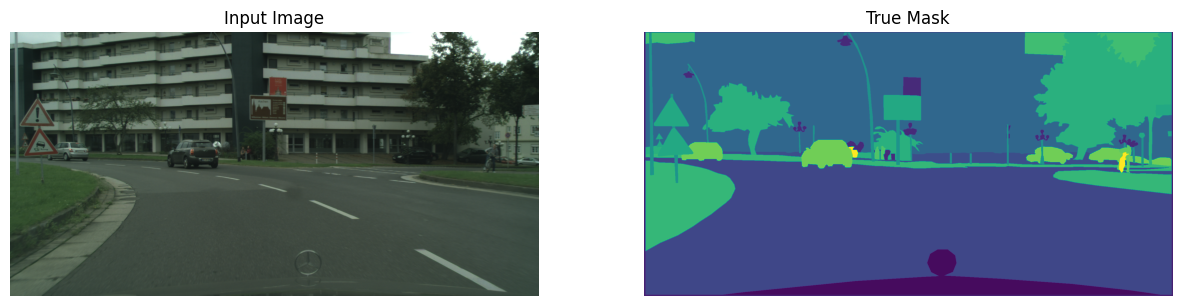

In [37]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


2025-08-02 16:50:36.802036: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


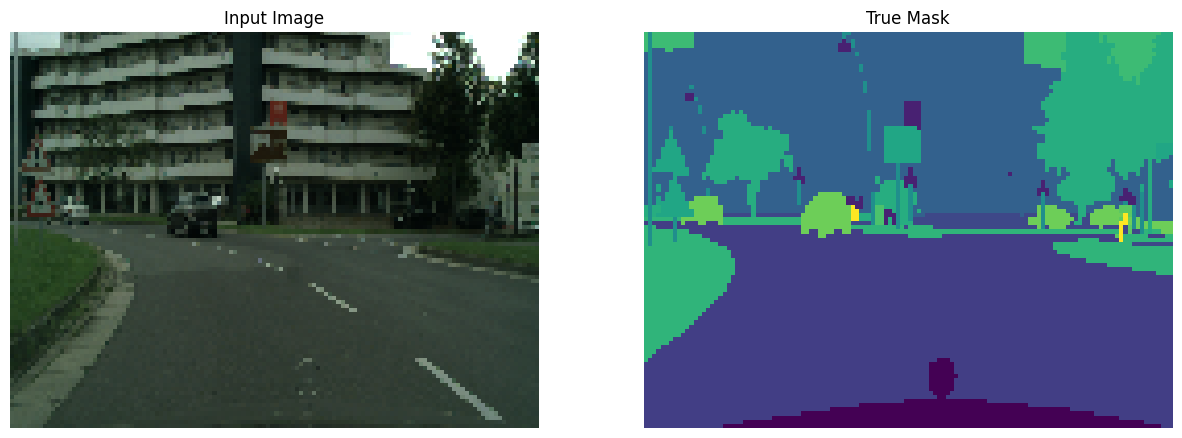

In [29]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

In [42]:
#Train the model
EPOCHS = 3    #should at least be 40
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 128   #32
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/3
24/24 ━━━━━━━━━━━━━━━━━━━━ 235s 9s/step - accuracy: 0.6173 - loss: 1.2022
Epoch 2/3
24/24 ━━━━━━━━━━━━━━━━━━━━ 204s 9s/step - accuracy: 0.6394 - loss: 1.1746
Epoch 3/3
24/24 ━━━━━━━━━━━━━━━━━━━━ 203s 8s/step - accuracy: 0.6500 - loss: 1.1520


In [43]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

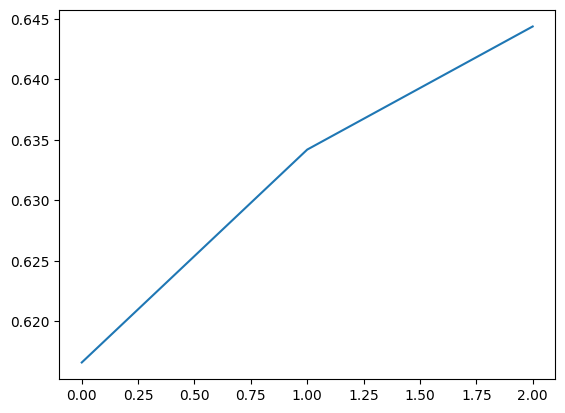

In [44]:
plt.plot(model_history.history["accuracy"])

In [45]:
def show_predictions(dataset=None, num=1):

    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 592ms/step


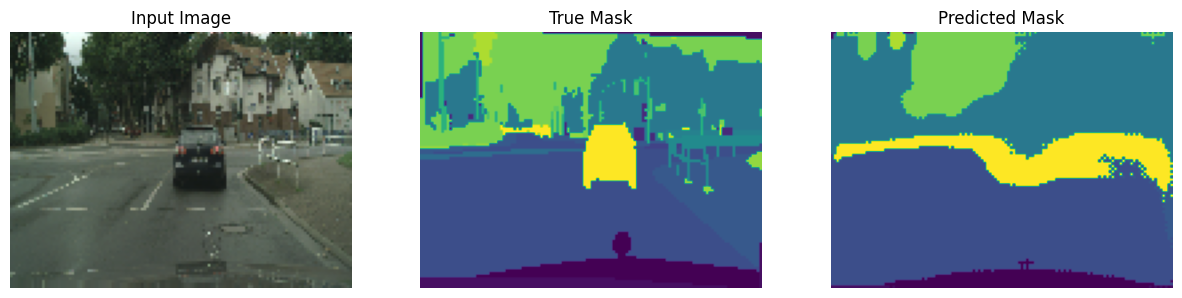

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 575ms/step


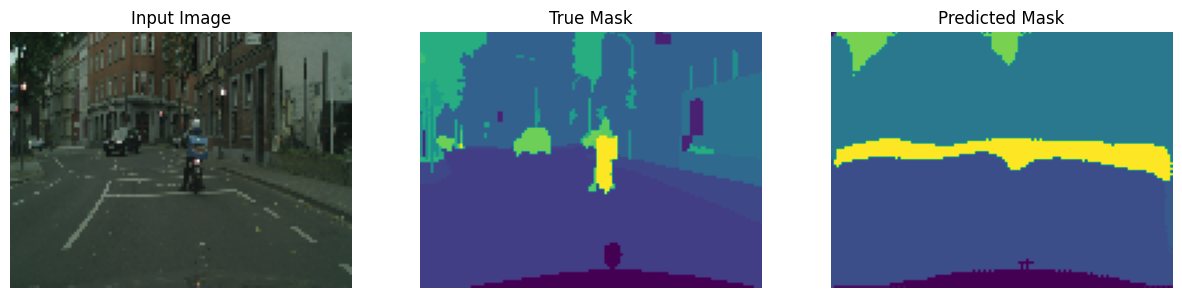

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 582ms/step


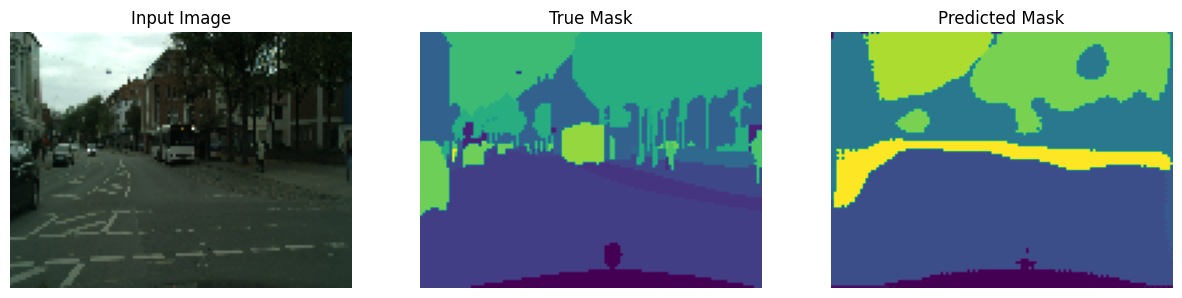

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 574ms/step


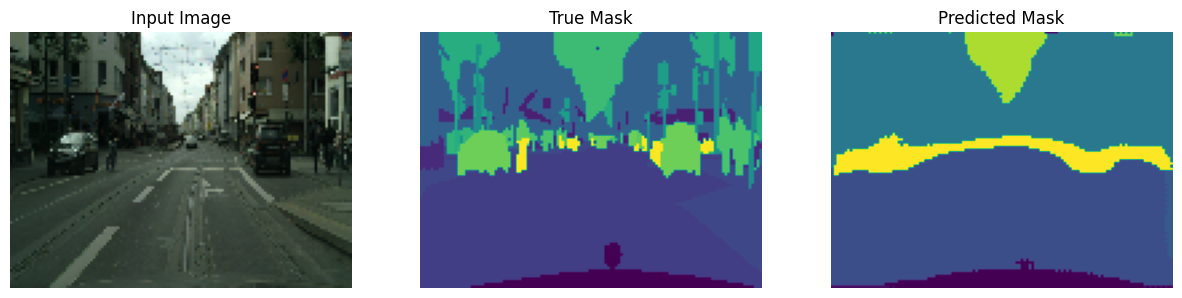

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 579ms/step


2025-08-02 17:16:24.952080: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


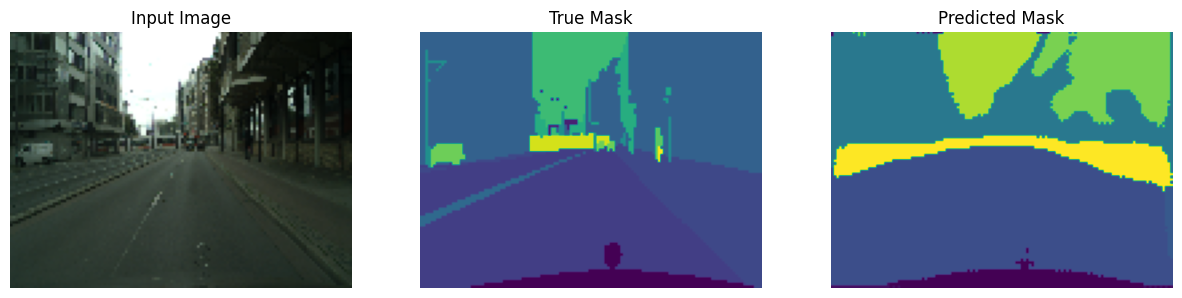

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 589ms/step


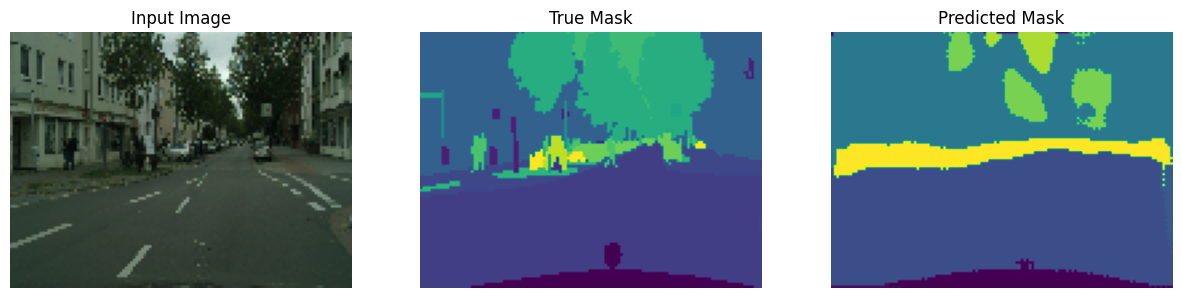

2025-08-02 17:16:27.747346: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [46]:
show_predictions(train_dataset, 6)